In [6]:
import tensorflow as tf
import zipfile
import os 
import random
import csv
import math
import shutil
from shutil import copyfile
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [ ]:
#extracting data from zip
try:
    local_zip = './data/archive_data/new_dataset.zip'
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall('./data/data_2')
    zip_ref.close()
#if data is already extracted it will instead print file already extracted
except:
    print('file already extracted')

In [29]:
path='./data/final_dataset/'
BATCH_SIZE=32
IMG_SIZE=(224,224)
train_dataset=image_dataset_from_directory(path,
                                          shuffle=True,
                                          batch_size=BATCH_SIZE,
                                          image_size=IMG_SIZE,
                                          validation_split=0.2,
                                          subset='training',
                                          seed=33)
validation_dataset=image_dataset_from_directory(path,
                                          shuffle=True,
                                          batch_size=BATCH_SIZE,
                                          image_size=IMG_SIZE,
                                          validation_split=0.2,
                                          subset='validation',
                                          seed=33)

Found 1912 files belonging to 2 classes.
Using 1530 files for training.
Found 1912 files belonging to 2 classes.
Using 382 files for validation.


In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

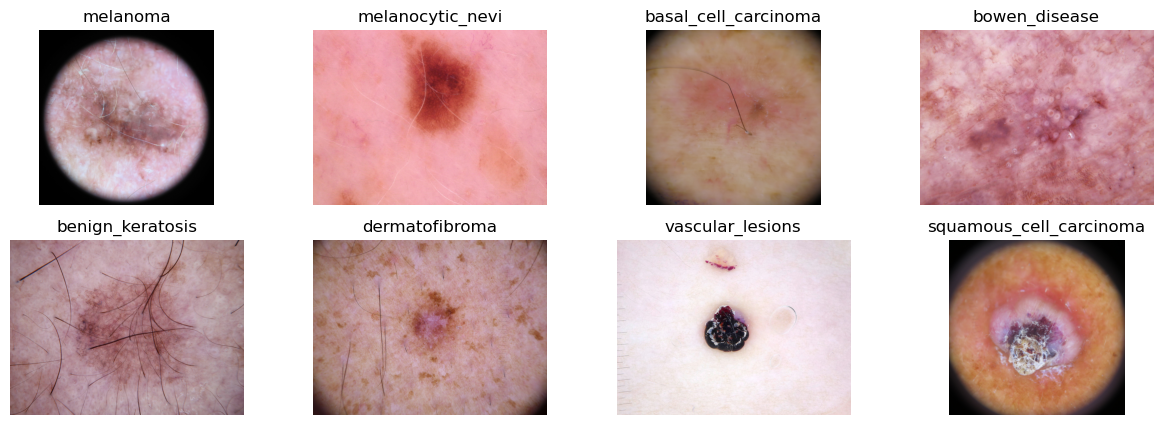

In [31]:
#show image example
dir_new = ['melanoma', 'melanocytic_nevi', 'basal_cell_carcinoma', 'bowen_disease', 'benign_keratosis', 'dermatofibroma', 'vascular_lesions', 'squamous_cell_carcinoma']
root_path = './data/final_dataset/training/'
fig, axes = plt.subplots(2, 4, figsize=(15,5))
counter = 0
for i in range(2):
    for j in range(4):
        ax = axes[i][j]
        ax.set_title(dir_new[counter])
        ax.imshow(load_img(f"{os.path.join(f'{root_path}/{dir_new[counter]}', os.listdir(f'{root_path+dir_new[counter]}')[random.randint(0,100)])}"))
        ax.set_axis_off()
        plt.show
        counter += 1

In [32]:
def data_augmenter ():
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        ])
    
    return data_augmentation

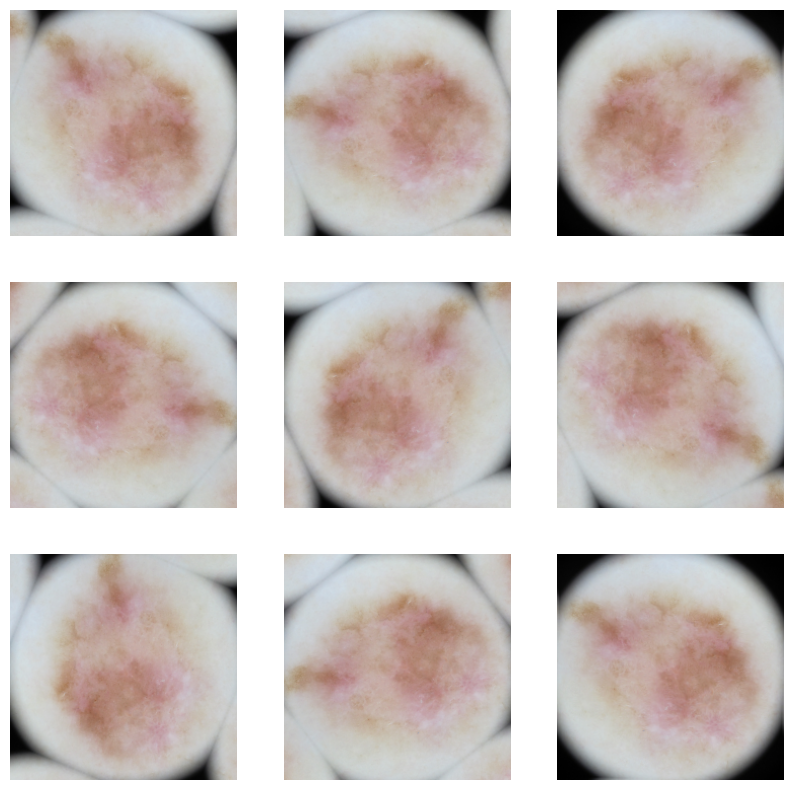

In [33]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [34]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable=False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [68]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
prediction_layer = tf.keras.layers.Dense(8, activation='softmax')

outputs = prediction_layer(x) 
model = tf.keras.Model(inputs, outputs)

In [69]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
initial_epochs = 50
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/50
48/48 [==============================] - 42s 864ms/step - loss: 0.2962 - accuracy: 0.8771 - val_loss: 0.6392 - val_accuracy: 0.7932
Epoch 2/50
48/48 [==============================] - 51s 1s/step - loss: 0.2825 - accuracy: 0.8804 - val_loss: 0.6564 - val_accuracy: 0.7932
Epoch 3/50
48/48 [==============================] - 49s 1s/step - loss: 0.2857 - accuracy: 0.8804 - val_loss: 0.7031 - val_accuracy: 0.7356
Epoch 4/50
48/48 [==============================] - 49s 1s/step - loss: 0.2635 - accuracy: 0.8987 - val_loss: 0.6771 - val_accuracy: 0.7958
Epoch 5/50
48/48 [==============================] - 47s 982ms/step - loss: 0.2698 - accuracy: 0.8830 - val_loss: 0.6852 - val_accuracy: 0.7958
Epoch 6/50
48/48 [==============================] - 47s 969ms/step - loss: 0.2822 - accuracy: 0.8850 - val_loss: 0.7093 - val_accuracy: 0.7539
Epoch 7/50
48/48 [==============================] - 46s 950ms/step - loss: 0.2706 - accuracy: 0.8863 - val_loss: 0.7281 - val_accuracy: 0.7513
Epoch 8/

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 12))

